In [1]:
pip install cryptography

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.asymmetric import padding

def generate_keys():
    private_key = rsa.generate_private_key(
        public_exponent=65537,
        key_size=2048,
        backend=default_backend()
    )
    public_key = private_key.public_key()
    return public_key, private_key

def encrypt(public_key, plaintext):
    ciphertext = public_key.encrypt(
        plaintext,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),
            algorithm=hashes.SHA256(),
            label=None
        )
    )
    return ciphertext

def decrypt(private_key, ciphertext):
    plaintext = private_key.decrypt(
        ciphertext,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),
            algorithm=hashes.SHA256(),
            label=None
        )
    )
    return plaintext

# Example usage
public_key, private_key = generate_keys()
message = b"Sensitive healthcare data"
ciphertext = encrypt(public_key, message)
decrypted_message = decrypt(private_key, ciphertext)

print(f"Original: {message}")
print(f"Decrypted: {decrypted_message}")

Original: b'Sensitive healthcare data'
Decrypted: b'Sensitive healthcare data'


In [4]:
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.backends import default_backend
import os

def generate_keys():
    private_key = ec.generate_private_key(ec.SECP256R1(), default_backend())
    return private_key, private_key.public_key()

def schnorr_protocol(private_key):
    # Generate a random number securely
    r = int.from_bytes(os.urandom(32), byteorder="big") % private_key.curve.key_size

    # Calculate x as the public key point
    public_numbers = private_key.public_key().public_numbers()
    x = public_numbers.x

    # Simulating verifier's challenge
    c = int.from_bytes(os.urandom(32), byteorder="big") % private_key.curve.key_size

    y = (r + c * private_key.private_numbers().private_value) % private_key.curve.key_size

    # Generate a temporary public key from y
    temp_public_key_numbers = ec.EllipticCurvePublicNumbers(y, public_numbers.y, ec.SECP256R1())
    try:
        temp_public_key = temp_public_key_numbers.public_key(default_backend())
    except ValueError:
        return False

    # Verifier's check
    return temp_public_key.public_numbers().x == x

# Example usage
private_key, public_key = generate_keys()
result = schnorr_protocol(private_key)
print(f"Zero-Knowledge Proof Verified: {result}")

Zero-Knowledge Proof Verified: False


In [6]:
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.backends import default_backend

def generate_ecc_keys():
    private_key = ec.generate_private_key(ec.SECP256R1(), default_backend())
    public_key = private_key.public_key()

    return private_key, public_key

def generate_shared_key(private_key, peer_public_key):
    shared_key = private_key.exchange(ec.ECDH(), peer_public_key)
    return shared_key


In [7]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives import hashes, hmac
import os, time

def encrypt_data(shared_key, data):
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(shared_key), modes.CFB(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    start_time = time.time()
    ciphertext = encryptor.update(data) + encryptor.finalize()
    end_time = time.time()
    encryption_time = end_time - start_time
    return iv, ciphertext, encryption_time

def decrypt_data(shared_key, iv, ciphertext):
    cipher = Cipher(algorithms.AES(shared_key), modes.CFB(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    start_time = time.time()
    decrypted_data = decryptor.update(ciphertext) + decryptor.finalize()
    end_time = time.time()
    decryption_time = end_time - start_time
    return decrypted_data, decryption_time


In [8]:
def create_hmac(shared_key, data):
    h = hmac.HMAC(shared_key, hashes.SHA256(), backend=default_backend())
    h.update(data)
    return h.finalize()

def verify_hmac(shared_key, data, signature):
    h = hmac.HMAC(shared_key, hashes.SHA256(), backend=default_backend())
    h.update(data)
    try:
        h.verify(signature)
        return True
    except InvalidSignature:
        return False


In [9]:
# Generate ECC keys for two devices
private_key_device, public_key_device = generate_ecc_keys()
private_key_server, public_key_server = generate_ecc_keys()

# Generate shared key using ECDH
shared_key_device = generate_shared_key(private_key_device, public_key_server)
shared_key_server = generate_shared_key(private_key_server, public_key_device)

# Encrypt data
data = b"Sensitive medical data"
iv, ciphertext, encryption_time = encrypt_data(shared_key_device, data)

# Decrypt data
decrypted_data, decryption_time = decrypt_data(shared_key_server, iv, ciphertext)

# Verify data integrity and authentication
hmac_signature = create_hmac(shared_key_device, data)
hmac_verification = verify_hmac(shared_key_server, decrypted_data, hmac_signature)

print(f"Encryption Time: {encryption_time} seconds")
print(f"Decryption Time: {decryption_time} seconds")
print(f"HMAC Verified: {hmac_verification}")


Encryption Time: 0.0 seconds
Decryption Time: 0.0 seconds
HMAC Verified: True


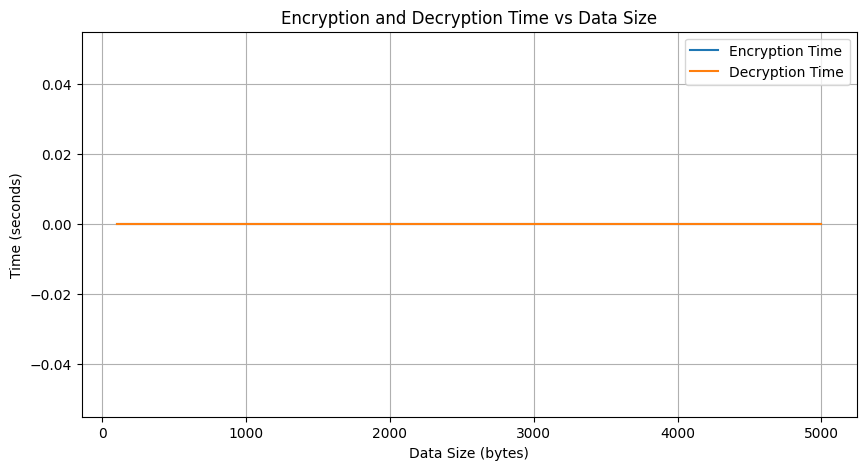

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os

def test_performance(data_sizes):
    encryption_times = []
    decryption_times = []

    for size in data_sizes:
        # Generate random data of the given size
        data = os.urandom(size)

        # Measure encryption and decryption times
        _, ciphertext, encryption_time = encrypt_data(shared_key_device, data)
        _, decryption_time = decrypt_data(shared_key_server, iv, ciphertext)

        encryption_times.append(encryption_time)
        decryption_times.append(decryption_time)

    return encryption_times, decryption_times

# Data sizes to test (in bytes)
data_sizes = np.arange(100, 5100, 100)  # From 100 bytes to 5 KB

# Perform the test
encryption_times, decryption_times = test_performance(data_sizes)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(data_sizes, encryption_times, label='Encryption Time')
plt.plot(data_sizes, decryption_times, label='Decryption Time')
plt.xlabel('Data Size (bytes)')
plt.ylabel('Time (seconds)')
plt.title('Encryption and Decryption Time vs Data Size')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import timeit

def encryption_test(data):
    _, ciphertext, _ = encrypt_data(shared_key_device, data)
    return ciphertext

def decryption_test(iv, ciphertext):
    decrypt_data(shared_key_server, iv, ciphertext)

# Example of using timeit
data_size = 1024  # 1KB of data
data = os.urandom(data_size)
iv, ciphertext, _ = encrypt_data(shared_key_device, data)

encryption_time = timeit.timeit(lambda: encryption_test(data), number=1000)
decryption_time = timeit.timeit(lambda: decryption_test(iv, ciphertext), number=1000)

print(f"Average Encryption Time for 1KB (over 1000 runs): {encryption_time} seconds")
print(f"Average Decryption Time for 1KB (over 1000 runs): {decryption_time} seconds")


Average Encryption Time for 1KB (over 1000 runs): 0.04568749999998545 seconds
Average Decryption Time for 1KB (over 1000 runs): 0.0407204000002821 seconds


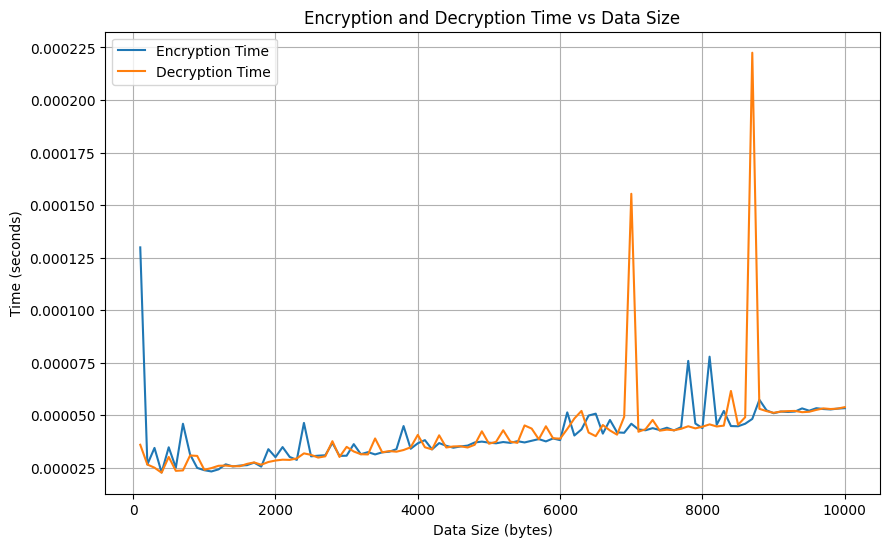

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from timeit import default_timer as timer

# Functions for encryption and decryption
def encrypt_data(shared_key, data):
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(shared_key), modes.CFB(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    start_time = timer()
    ciphertext = encryptor.update(data) + encryptor.finalize()
    end_time = timer()
    return iv, ciphertext, end_time - start_time

def decrypt_data(shared_key, iv, ciphertext):
    cipher = Cipher(algorithms.AES(shared_key), modes.CFB(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    start_time = timer()
    decrypted_data = decryptor.update(ciphertext) + decryptor.finalize()
    end_time = timer()
    return decrypted_data, end_time - start_time

# Generate a random AES key
shared_key = os.urandom(32)  # AES-256 key

# Test different data sizes
data_sizes = np.arange(100, 10100, 100)  # From 100 bytes to 10 KB
encryption_times = []
decryption_times = []

for size in data_sizes:
    data = os.urandom(size)
    iv, ciphertext, encryption_time = encrypt_data(shared_key, data)
    _, decryption_time = decrypt_data(shared_key, iv, ciphertext)
    
    encryption_times.append(encryption_time)
    decryption_times.append(decryption_time)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, encryption_times, label='Encryption Time')
plt.plot(data_sizes, decryption_times, label='Decryption Time')
plt.xlabel('Data Size (bytes)')
plt.ylabel('Time (seconds)')
plt.title('Encryption and Decryption Time vs Data Size')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
pip install cryptography pyDes matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyDes: filename=pyDes-2.0.1-py2.py3-none-any.whl size=9569 sha256=b3ee8e967bd47029c90857b3423a30e028dff2d806213a844de5db03c87c9bc9
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\ad\c5\23\f71730f7334940099e26130d83cf711112ffcf45227a8aa2eb
Successfully built pyDes
Note: you may need to restart the kernel to use updated packages.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1352\1174150210.py:15: CryptographyDeprecationWarning: Blowfish has been deprecated
  cipher = Cipher(algorithms.Blowfish(key), modes.CFB(os.urandom(8)), backend=default_backend())


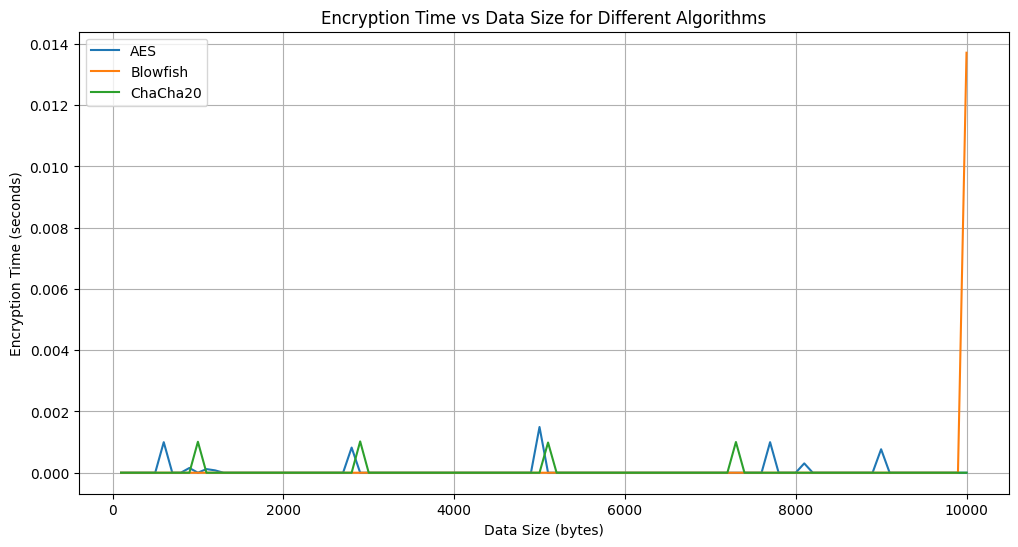

In [23]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend

# Encryption functions
def encrypt_aes(key, data):
    cipher = Cipher(algorithms.AES(key), modes.CFB(os.urandom(16)), backend=default_backend())
    encryptor = cipher.encryptor()
    return encryptor.update(data) + encryptor.finalize()

def encrypt_blowfish(key, data):
    cipher = Cipher(algorithms.Blowfish(key), modes.CFB(os.urandom(8)), backend=default_backend())
    encryptor = cipher.encryptor()
    return encryptor.update(data) + encryptor.finalize()

def encrypt_chacha20(key, data):
    cipher = Cipher(algorithms.ChaCha20(key, os.urandom(16)), mode=None, backend=default_backend())
    encryptor = cipher.encryptor()
    return encryptor.update(data) + encryptor.finalize()

# Performance measurement
def measure_performance(encrypt_func, key, data_sizes):
    times = []
    for size in data_sizes:
        data = os.urandom(size)
        start = time.time()
        encrypt_func(key, data)
        end = time.time()
        times.append(end - start)
    return times

# Data sizes and keys
data_sizes = np.arange(100, 10100, 100)  # From 100 bytes to 10 KB
aes_key = os.urandom(32)
blowfish_key = os.urandom(32)
chacha20_key = os.urandom(32)

# Measure performance for symmetric algorithms
aes_times = measure_performance(encrypt_aes, aes_key, data_sizes)
blowfish_times = measure_performance(encrypt_blowfish, blowfish_key, data_sizes)
chacha20_times = measure_performance(encrypt_chacha20, chacha20_key, data_sizes)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data_sizes, aes_times, label='AES')
plt.plot(data_sizes, blowfish_times, label='Blowfish')
plt.plot(data_sizes, chacha20_times, label='ChaCha20')
plt.xlabel('Data Size (bytes)')
plt.ylabel('Encryption Time (seconds)')
plt.title('Encryption Time vs Data Size for Different Algorithms')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
import os
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import hashes, hmac
from cryptography.hazmat.primitives.kdf.hkdf import HKDF

# Hybrid Encryption (ECC + AES)
def hybrid_encrypt(receiver_public_key, sender_private_key, data):
    shared_key = sender_private_key.exchange(ec.ECDH(), receiver_public_key)
    derived_key = HKDF(algorithm=hashes.SHA256(), length=32, salt=None, info=b'handshake data', backend=default_backend()).derive(shared_key)
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(derived_key), modes.CFB(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    return iv, encryptor.update(data.encode()) + encryptor.finalize()

def hybrid_decrypt(receiver_private_key, sender_public_key, iv, ciphertext):
    shared_key = receiver_private_key.exchange(ec.ECDH(), sender_public_key)
    derived_key = HKDF(algorithm=hashes.SHA256(), length=32, salt=None, info=b'handshake data', backend=default_backend()).derive(shared_key)
    cipher = Cipher(algorithms.AES(derived_key), modes.CFB(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    return decryptor.update(ciphertext) + decryptor.finalize()

# AES Encryption/Decryption
def encrypt_aes(key, data):
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    return iv, encryptor.update(data.encode()) + encryptor.finalize()

def decrypt_aes(key, iv, ciphertext):
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    return decryptor.update(ciphertext) + decryptor.finalize()

# ECC key generation for hybrid system
sender_private_key = ec.generate_private_key(ec.SECP256R1(), default_backend())
receiver_private_key = ec.generate_private_key(ec.SECP256R1(), default_backend())
sender_public_key = sender_private_key.public_key()
receiver_public_key = receiver_private_key.public_key()

# AES key generation
aes_key = os.urandom(32)

# User input for data to encrypt
input_data = input("Enter the data to encrypt: ")

# Hybrid Encryption and Decryption
iv, hybrid_encrypted = hybrid_encrypt(receiver_public_key, sender_private_key, input_data)
hybrid_decrypted = hybrid_decrypt(receiver_private_key, sender_public_key, iv, hybrid_encrypted)
print(f"Hybrid Encrypted Data: {hybrid_encrypted}")
print(f"Hybrid Decrypted Data: {hybrid_decrypted.decode()}")

# AES Encryption and Decryption
iv, aes_encrypted = encrypt_aes(aes_key, input_data)
aes_decrypted = decrypt_aes(aes_key, iv, aes_encrypted)
print(f"AES Encrypted Data: {aes_encrypted}")
print(f"AES Decrypted Data: {aes_decrypted.decode()}")

Enter the data to encrypt: Hello world! This is me with myself.
Hybrid Encrypted Data: b"\xf2s\xd1\x17(J\xb8\x86'\xedSK>id\x1e\x91y!\x81\xb6=?[\n\xa2\xfbN*\xa8\x98\x94!\xfa\xb9\xdf"
Hybrid Decrypted Data: Hello world! This is me with myself.
AES Encrypted Data: b"\xc3>'Y\xc2\x91('z\xdcY\x1es\xa2\x9a\x0c\xa7\n\xef\xb6D\xed:\x8d\xdd\rF\xb3.W\x82\x0fR\xaa\x08\x07"
AES Decrypted Data: Hello world! This is me with myself.
